In [2]:
# import  os
# #set visibile cuda
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from corner import corner

import torch
import torch.nn as nn
import torch.optim as optim 
import normflows as nf
import emcee
device='cuda'

In [2]:
from tools.noise_scheduler import noise_scheduler
from tools.loss import unified_loss
from tools.score_net import score_model_mlp,score_model_mlp_cond
from tools.sampling import ddpm_sampler,annealed_langevin_dynamic_sampler

$$
\begin{aligned}f(x\mid\alpha,\beta)&=\frac1{\Gamma(\alpha)\beta^\alpha}x^{\alpha-1}e^{-x/\beta}\end{aligned}
$$
$$
\left.\frac\partial{\partial\theta}\log f(X\mid\theta)=\left(\begin{array}{c}\frac\partial{\partial\alpha}\log f\\\frac\partial{\partial\beta}\log f\end{array}\right.\right)=\left(\begin{array}{c}-\psi(\alpha)-\log\beta+\log X\\-\frac\alpha\beta+\frac X{\beta^2}\end{array}\right)
$$
$$
\left.I(\theta)=-E\left(\begin{array}{cc}\frac{\partial^2l}{\partial\alpha^2}&\frac{\partial^2l}{\partial\alpha\partial\beta}\\\frac{\partial^2l}{\partial\beta\partial\alpha}&\frac{\partial^2l}{\partial\beta^2}\end{array}\right.\right)=-E\left(\begin{array}{cc}-\psi^{\prime}(\alpha)&\frac{-1}\beta\\\frac{-1}\beta&\frac\alpha{\beta^2}-\frac{2X}{\beta^3}\end{array}\right)=\left(\begin{array}{cc}\psi^{\prime}(\alpha)&\frac1\beta\\\frac1\beta&\frac\alpha{\beta^2}\end{array}\right)
$$
$$
\left.I(\theta)^{-1}=\frac{\beta^2}{\alpha\psi^{\prime}(\alpha)-1}\left(\begin{array}{cc}\frac\alpha{\beta^2}&-\frac1\beta\\-\frac1\beta&\psi^{\prime}(\alpha)\end{array}\right.\right)=\frac1{\alpha\psi^{\prime}(\alpha)-1}\left(\begin{array}{cc}\alpha&-\beta\\-\beta&\beta^2\psi^{\prime}(\alpha)\end{array}\right)
$$

In [3]:
from scipy.special import polygamma,digamma,gamma

from scipy.stats import gamma as gamma_dis

N_obs=100

# def gamma_simulator(thetas):
#     alpha, beta = thetas[:, 0], thetas[:, 1]
#     n_samples = thetas.shape[0]
#     return np.random.gamma(alpha, beta, (n_samples))

def gamma_simulator(thetas):
    alpha, beta = thetas[:,:1], thetas[:,1:]
    samples = np.random.gamma(alpha, beta, size=(thetas.shape[0], N_obs))
    return samples

def gamma_log_likelihood( thetas,x):
    alpha, beta = thetas[:,:1], thetas[:,1:]
    # return (-alpha * np.log(beta) - np.log(gamma(alpha)) + (alpha - 1) * np.log(x) - x/beta)
    return gamma_dis.logpdf(x, alpha, scale=beta).sum(1)

def gamma_fisher_score( thetas,x):
    alpha, beta = thetas[:,:1], thetas[:,1:]
    grad_alpha =( -digamma(alpha) + np.log(x) - np.log(beta)).sum(1)
    grad_beta = (-alpha / beta + x/beta**2).sum(1)
    return np.stack([grad_alpha, grad_beta], 1)

def gamma_fisher_information(thetas):
    alpha, beta = thetas[:,0], thetas[:,1]
    I_00= polygamma(1, alpha)
    I_11= alpha/(beta**2)
    I_01= 1/beta
    I_10= 1/beta
    #stack in to a Nx2x2 array
    return N_obs*np.stack([np.stack([I_00, I_01], 1), np.stack([I_10, I_11], 1)], 1)

In [114]:
thetas_prior_param=[2,3]

def prior_thetas(n_samples):
    thetas = np.random.uniform(thetas_prior_param[0],thetas_prior_param[1],(n_samples,2))
    return thetas

# def prior_thetas(n_samples):
#     thetas = np.random.normal(thetas_prior_param[0],thetas_prior_param[1],(n_samples,2))  
#     return thetas

#score for guassian with respect to x
# def gaussian_sample_score(thetas_prior_param, thetas):
#     score= ((thetas_prior_param[:,0]-thetas)/thetas_prior_param[:,1]**2)
#     return score

In [125]:
test_theta=prior_thetas(1)
test_obs = gamma_simulator(test_theta)

(2.0, 3.0)

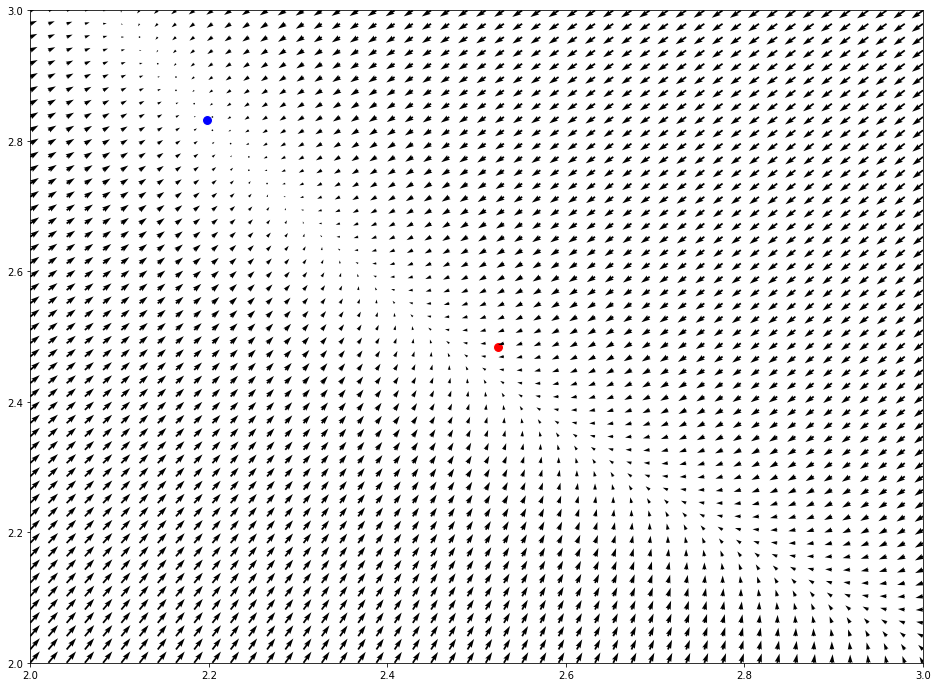

In [129]:
plot_range = [2,3]

xx = np.stack(np.meshgrid(np.linspace(*plot_range, 50), np.linspace(*plot_range, 50)), axis=-1).reshape(-1, 2)
# idx = np.random.randint(2500)
# obs = (gamma_simulator(xx[idx][None,:]))

mle_solution= gamma_dis.fit(test_obs, floc=0)
mle_alpha, mle_beta = mle_solution[0], mle_solution[2]

true_fs=gamma_fisher_score(xx,test_obs)

true_fs_norm = np.linalg.norm(true_fs, axis=-1, ord=2, keepdims=True)
true_fs_log1p = true_fs / (true_fs_norm + 1e-9) * np.log1p(true_fs_norm)

# Perform the plots
plt.figure(figsize=(16,12))
# plt.scatter(*thetas.detach().cpu().T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.scatter(*test_theta[0], color='red', edgecolor='white', s=100)
plt.scatter([mle_alpha], [mle_beta], color='blue', edgecolor='white', s=100)
plt.quiver(*xx.T, *true_fs_log1p.T, width=0.002, color='black')
# plt.quiver(*xx.T, *true_fisher_score.T, width=0.002, color='black')
plt.xlim(*plot_range)
plt.ylim(*plot_range)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

(2.0, 3.0)

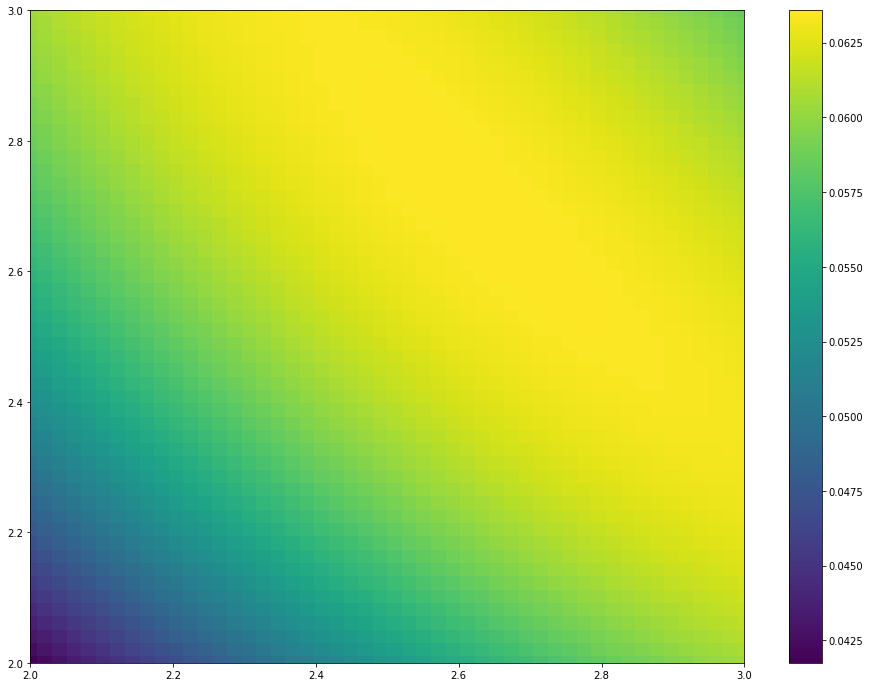

In [30]:
# xx = np.stack(np.meshgrid(np.linspace(*plot_range, 50), np.linspace(*plot_range, 50)), axis=-1).reshape(-1, 2)

likelihood = np.exp(gamma_log_likelihood(xx,test_obs)/N_obs)
# likelihood = gamma_dis.pdf(obs, a=xx[:,0], scale=xx[:,1])

# Perform the plots
plt.figure(figsize=(16,12))

plt.pcolormesh(xx[:,0].reshape(50,50), xx[:,1].reshape(50,50), likelihood.reshape(50,50), cmap='viridis', shading='auto')
plt.colorbar()
plt.xlim(*plot_range)
plt.ylim(*plot_range)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

In [10]:
#use emcee to sample from the posterior

thetas_prior_param=[1e-5,10]

def log_likelihood(thetas, x):
    thetas=thetas[None,:]
    return gamma_log_likelihood(thetas,x)[0]

def log_prior(thetas):
    #uniform prior
    if np.all(thetas>thetas_prior_param[0]) and np.all(thetas<thetas_prior_param[1]):
        return 0
    else:
        return -np.inf

def log_posterior(thetas, x):

    if np.all(thetas>thetas_prior_param[0]) and np.all(thetas<thetas_prior_param[1]):
        return log_likelihood(thetas,x)
    else:
        return -np.inf

# def guassian_log_likelihood(thetas, x):
#     mu, sigma= thetas[0],thetas[1]
#     return -0.5*np.log(2*np.pi*sigma**2)-0.5*(x-mu)**2/sigma**2

# def log_likelihood(thetas, x):
#     alpha, beta= thetas[0],thetas[1]
#     prob = sigmoid(alpha+beta*factor)
#     likelihood = x * prob + (1 - x) * np.log(1 - prob)
#     return likelihood.sum()

# def prior_log_prob(thetas):
#     alpha, beta= thetas[0],thetas[1]
#     return guassian_log_likelihood(thetas_prior_param,alpha)+guassian_log_likelihood(thetas_prior_param,beta)

# def log_posterior(thetas, x):
#     return log_likelihood(thetas,x) + prior_log_prob(thetas)


ndim, nwalkers = 2, 10
nsteps, nburn = 10000, 100   
pos = np.array([test_theta[0] + np.abs(1e-1*np.random.randn(ndim)) for i in range(nwalkers)])
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[test_obs])

sampler.run_mcmc(pos, nsteps, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:15<00:00, 665.89it/s]


Text(0.5, 0.98, '[[2.86191358 2.03819906]]')

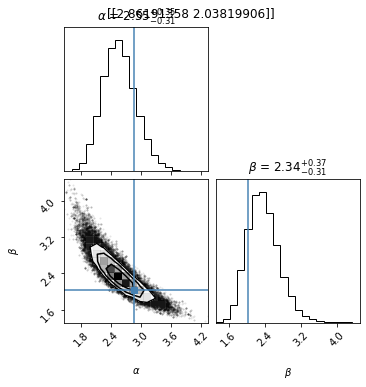

In [11]:
ref_pos= sampler.chain[:,nburn:,:].reshape(-1,ndim)
corner(ref_pos,labels=[r'$\alpha$',r'$\beta$'],show_titles=True,truths=test_theta[0]);
plt.suptitle(f'{test_theta}')

### Posterior Score Fitting

In [31]:
thetas_prior_param=[1,5]
thetas=prior_thetas(100000)
samples=gamma_simulator(thetas)

In [32]:
# thetas_prior_param=[1,2]
#norm thetas
# thetas_normed=(thetas-thetas_prior_param[0])/(thetas_prior_param[1]-thetas_prior_param[0])

# def normed_thetas(thetas):
#     return (thetas-thetas_prior_param[0])/(thetas_prior_param[1]-thetas_prior_param[0])

# def inverse_normed_thetas(thetas_normed):
#     return thetas_normed*(thetas_prior_param[1]-thetas_prior_param[0])+thetas_prior_param[0]
thetas_normed = thetas

def normed_thetas(thetas):
    return thetas

def inverse_normed_thetas(thetas_normed):
    return thetas_normed

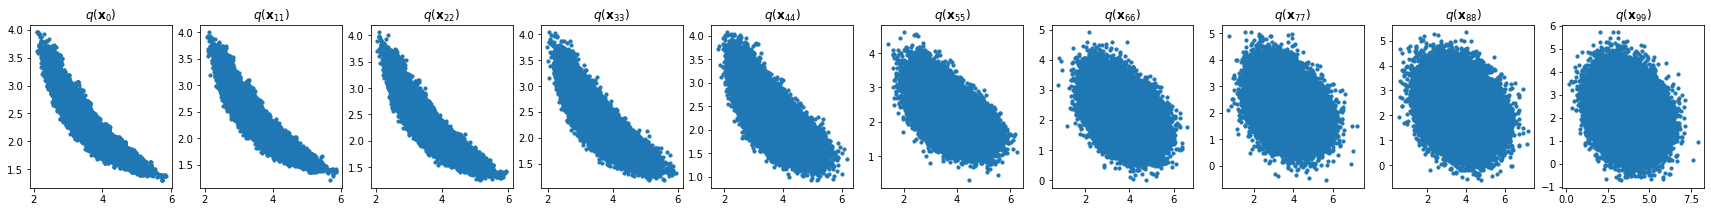

In [31]:
ns=noise_scheduler(1e-5,1e-2,100,schedule='sigmoid',var_norm=False)
ns.visualize_noise(torch.tensor(normed_thetas(ref_pos)))

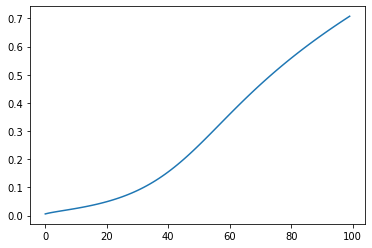

tensor([0.0059, 0.0085, 0.0107, 0.0126, 0.0145, 0.0163, 0.0180, 0.0198, 0.0216,
        0.0235, 0.0254, 0.0273, 0.0294, 0.0315, 0.0337, 0.0360, 0.0384, 0.0409,
        0.0436, 0.0464, 0.0493, 0.0524, 0.0557, 0.0592, 0.0628, 0.0666, 0.0707,
        0.0750, 0.0795, 0.0842, 0.0893, 0.0945, 0.1001, 0.1059, 0.1120, 0.1184,
        0.1252, 0.1322, 0.1395, 0.1472, 0.1552, 0.1634, 0.1720, 0.1809, 0.1901,
        0.1995, 0.2092, 0.2191, 0.2293, 0.2396, 0.2502, 0.2608, 0.2716, 0.2826,
        0.2936, 0.3046, 0.3157, 0.3268, 0.3379, 0.3490, 0.3600, 0.3709, 0.3818,
        0.3926, 0.4034, 0.4140, 0.4245, 0.4349, 0.4451, 0.4553, 0.4653, 0.4752,
        0.4850, 0.4947, 0.5042, 0.5136, 0.5229, 0.5320, 0.5410, 0.5500, 0.5588,
        0.5674, 0.5760, 0.5845, 0.5929, 0.6011, 0.6093, 0.6174, 0.6253, 0.6332,
        0.6410, 0.6487, 0.6563, 0.6639, 0.6713, 0.6787, 0.6860, 0.6932, 0.7004,
        0.7075])

In [32]:
ns.plot_marginal_std()
ns.marg_std

In [61]:
class score_model_mlp_cond(nn.Module):
    def __init__(self, input_dim, cond_dim, n_steps, hidden=[128,128]):
        '''
        current model
        activation function: GELU
        dropout: 0.2
        embedding: directly add to input
        '''
        super().__init__()
        self.input = nn.Sequential(
            nn.Linear(input_dim+cond_dim, hidden[0]),
            nn.Dropout(0.2),
            nn.GELU()
        )
        # Condition time t
        self.embedding_layer = nn.Embedding(n_steps, hidden[0])
        # self.cond_emb=nn.Linear(cond_dim,cond_dim)
        
        self.hidden_layers = nn.ModuleList([nn.Sequential(
            nn.Linear(hidden[i], hidden[i+1]),
            nn.Dropout(0.2),
            nn.GELU()
        ) for i in range(len(hidden)-1)])

        self.output = nn.Linear(hidden[-1], input_dim)

        self.marg_std=ns.marg_std.to(device)


    def forward(self, x, x_cond, t):
        # x_cond = self.cond_emb(x_cond)
        x = torch.cat([x,x_cond],dim=1)
        x = self.input(x) + self.embedding_layer(t)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output(x)/self.marg_std[t][:,None]
        return x

In [62]:
pos_model = score_model_mlp_cond(input_dim=2,cond_dim=100,n_steps=100,hidden=[256,512,512]).to(device)
optimizer = optim.Adam(pos_model.parameters(), lr=1e-3)

In [63]:
dataset=torch.tensor(samples).float().to(device)
thetas_normed=torch.tensor(thetas_normed).float().to(device)
epochs = 1000
batch_size = 1000
for epoch in range(epochs):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = thetas_normed[indices]
        batch_x_cond = dataset[indices]

        t = torch.randint(0, ns.n_steps, size=(batch_x.shape[0] // 2 + 1,))
        t = torch.cat([t, ns.n_steps - t - 1], dim=0)[:batch_x.shape[0]].long().to(device)
        # Compute the loss.
        loss = unified_loss(pos_model, batch_x,t,ns,batch_x_cond)

        optimizer.zero_grad()
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(pos_model.parameters(), 1.)
        optimizer.step()

    if (epoch % 100 == 0):
        print(loss.item())


/tmp/ipykernel_1186617/2969528858.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas_normed=torch.tensor(thetas_normed).float().to(device)


0.9579222202301025
0.6228005290031433
0.6282463073730469
0.6237240433692932
0.5581974983215332
0.5668262243270874
0.6528360843658447
0.5916274785995483
0.6530550718307495
0.5794515609741211


In [64]:
sampler=annealed_langevin_dynamic_sampler(pos_model,ns,n_iter_each_T=100,device=device,eps=1e-5)
# sampler = ddpm_sampler(pos_model,ns,device)

In [65]:
# sample_cond=torch.tensor(np.repeat(test_obs,thetas.shape[0],axis=0)).float().to(device)
# x_seq=sampler.loop_sample(thetas.shape,sample_cond=sample_cond)

sample_cond=torch.tensor(np.repeat(test_obs,10000,axis=0)).float().to(device)
x_seq=sampler.loop_sample((10000,2),sample_cond=sample_cond)

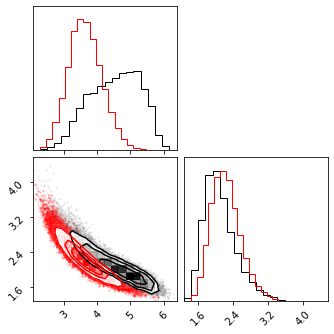

In [66]:
final=(x_seq[-1].detach().cpu().numpy())
#remove nan in final
# final=final[~np.isnan(final).any(axis=1)]
final=inverse_normed_thetas(final)
fig=corner(final,hist_kwargs={'density':True});
corner(ref_pos,fig=fig,color='red',hist_kwargs={'density':True});


In [67]:
from tools.utils import plot_gradient

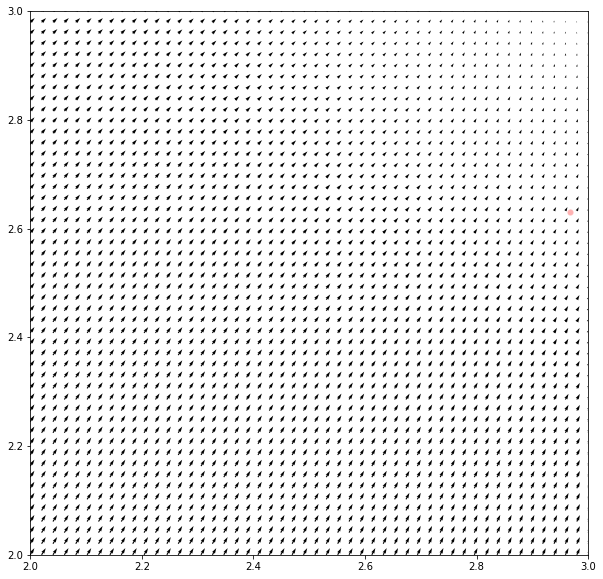

In [68]:
plot_gradient(pos_model,(2,3),(2,3),n=50,t=0,score_cond=(test_obs[0]),ref_data=normed_thetas(test_theta))

(2.0, 3.0)

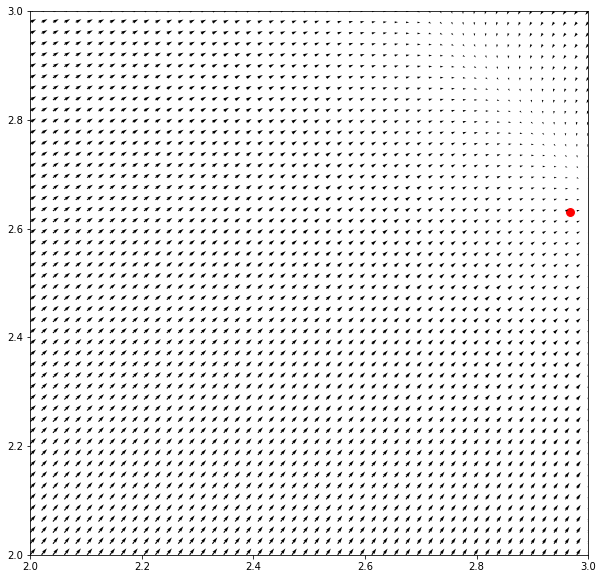

In [69]:
xx = np.stack(np.meshgrid(np.linspace(2, 3, 50), np.linspace(2, 3, 50)), axis=-1).reshape(-1, 2)

obs = test_obs
mle_solution= gamma_dis.fit(obs, floc=0)
mle_alpha, mle_beta = mle_solution[0], mle_solution[2]

true_fs=gamma_fisher_score(xx,obs)


scores_norm = np.linalg.norm(true_fs, axis=-1, ord=2, keepdims=True)
scores_log1p = true_fs / (scores_norm + 1e-9) * np.log1p(scores_norm)

# Perform the plots
plt.figure(figsize=(10,10))
# plt.scatter(*thetas.detach().cpu().T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.scatter(*test_theta.T, color='red', edgecolor='white', s=100)
plt.scatter([mle_alpha], [mle_beta], color='blue', edgecolor='white', s=100)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
# plt.quiver(*xx.T, *true_fisher_score.T, width=0.002, color='black')
plt.xlim(2,3)
plt.ylim(2,3)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

In [93]:
xx = np.stack(np.meshgrid(np.linspace(2,3, 50), np.linspace(2, 3, 50)), axis=-1).reshape(-1, 2)

obs = test_obs
mle_solution= gamma_dis.fit(obs, floc=0)
mle_alpha, mle_beta = mle_solution[0], mle_solution[2]

true_fs=gamma_fisher_score(xx,obs)

xx = torch.tensor(normed_thetas(xx)).float().to(device)
x_cond = torch.tensor(np.repeat(obs,xx.shape[0],axis=0),dtype=torch.float32).to(device)
labels = torch.ones(xx.shape[0],dtype=torch.long).to(device)*0
estimated_fs = pos_model(xx,x_cond,labels).detach().cpu().numpy()

In [94]:
def norm_score(score):
    scores_norm = np.linalg.norm(score, axis=-1, ord=2, keepdims=True)
    scores_log1p = true_fs / (scores_norm + 1e-9) * np.log1p(scores_norm)

    return scores_log1p

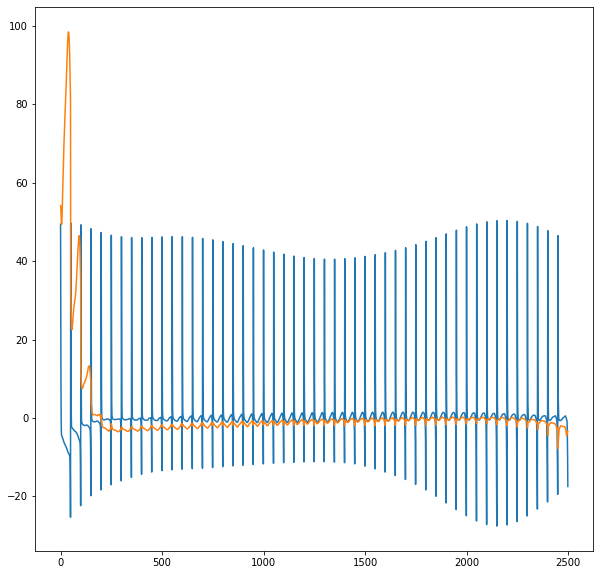

In [95]:
plt.figure(figsize=(10,10))
plt.plot((estimated_fs)-(true_fs))

In [70]:
def estimate_fisher_score(x,theta):
    labels=torch.ones(x.shape[0]).long().to(device)*0

    with torch.no_grad():
        pos_score=pos_model(theta,x,labels)
        fs=pos_score#-prior_score

    return fs.cpu().numpy()#,pos_score.cpu().numpy(),prior_score.cpu().numpy()

def estimate_fisher_information(theta,N_trial=10000):

    true_thetas = torch.tensor(np.repeat(theta, N_trial, axis=0)).float()
    true_thetas_samples = gamma_simulator(true_thetas)

    #calcuate the fisher score at every sample in true_thetas_samples
    temp_fs=estimate_fisher_score(torch.tensor(true_thetas_samples).float().to(device),torch.tensor(true_thetas).float().to(device))

    true_fs=gamma_fisher_score(theta,true_thetas_samples)

    # temp_fs= temp_fs-np.mean(temp_fs,axis=0)
    #estimate fisher matrix through averaging
    estimated_fm=(temp_fs[:,:,None]*temp_fs[:,None,:]).mean(axis=0)

    return estimated_fm,temp_fs,true_fs
    

In [71]:
fm,efs,tfs=estimate_fisher_information(normed_thetas(test_theta))

/tmp/ipykernel_1186617/4123445992.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  temp_fs=estimate_fisher_score(torch.tensor(true_thetas_samples).float().to(device),torch.tensor(true_thetas).float().to(device))


In [72]:
tfs.shape

(10000, 2)

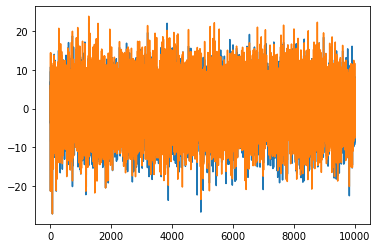

In [73]:
plt.plot(tfs)

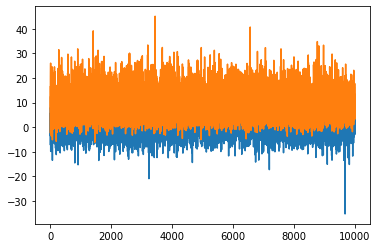

In [74]:
plt.plot(efs)

In [58]:
fm

array([[17.095526, 18.292217],
       [18.292217, 28.139912]], dtype=float32)

In [57]:
gamma_fisher_information(test_theta)

array([[[40.01547319, 38.01928101],
        [38.01928101, 42.88063204]]])

In [33]:
def dsm_score_estimation(scorenet, samples, samples_cond , sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples, samples_cond)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)

    # print(target.shape, scores.shape)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)

    return loss

In [34]:
import torch.autograd as autograd

def jacobian(f, x):
    """Computes the Jacobian of f w.r.t x.
    :param f: function R^N -> R^N
    :param x: torch.tensor of shape [B, N]
    :return: Jacobian matrix (torch.tensor) of shape [B, N, N]
    """
    B, N = x.shape
    y = f(x)
    jacobian = list()
    for i in range(N):
        v = torch.zeros_like(y)
        v[:, i] = 1.
        dy_i_dx = autograd.grad(y, x, grad_outputs=v, retain_graph=True, create_graph=True, allow_unused=True)[0]  # shape [B, N]
        jacobian.append(dy_i_dx)
    jacobian = torch.stack(jacobian, dim=2).requires_grad_()
    return jacobian


def score_matching(model, samples, train=False):
    samples.requires_grad_(True)
    logp = model(samples)
    # Compute the norm loss
    norm_loss = torch.norm(logp, dim=-1) ** 2 / 2.
    # Compute the Jacobian loss
    jacob_mat = jacobian(model, samples)
    tr_jacobian_loss = torch.diagonal(jacob_mat, dim1=-2, dim2=-1).sum(-1)
    return (tr_jacobian_loss + norm_loss).mean(-1)

In [35]:
def sliced_score_estimation_vr(score_net, samples, n_particles=1):
    """
    Be careful if the shape of samples is not B x x_dim!!!!
    """
    dup_samples = samples.unsqueeze(0).expand(n_particles, *samples.shape).contiguous().view(-1, *samples.shape[1:])
    dup_samples.requires_grad_(True)
    vectors = torch.randn_like(dup_samples)

    grad1 = score_net(dup_samples)
    gradv = torch.sum(grad1 * vectors)
    grad2 = autograd.grad(gradv, dup_samples, create_graph=True)[0]

    grad1 = grad1.view(dup_samples.shape[0], -1)
    loss1 = torch.sum(grad1 * grad1, dim=-1) / 2.

    loss2 = torch.sum((vectors * grad2).view(dup_samples.shape[0], -1), dim=-1)

    loss1 = loss1.view(n_particles, -1).mean(dim=0)
    loss2 = loss2.view(n_particles, -1).mean(dim=0)

    loss = loss1 + loss2
    return loss.mean(), loss1.mean(), loss2.mean()


def anneal_sliced_score_estimation_vr(scorenet, samples, labels, sigmas, n_particles=1):
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
    perturbed_samples = samples + torch.randn_like(samples) * used_sigmas
    dup_samples = perturbed_samples.unsqueeze(0).expand(n_particles, *samples.shape).contiguous().view(-1,
                                                                                                       *samples.shape[
                                                                                                        1:])
    dup_labels = labels.unsqueeze(0).expand(n_particles, *labels.shape).contiguous().view(-1)
    dup_samples.requires_grad_(True)

    # use Rademacher
    vectors = torch.randn_like(dup_samples)

    grad1 = scorenet(dup_samples, dup_labels)
    gradv = torch.sum(grad1 * vectors)
    grad2 = autograd.grad(gradv, dup_samples, create_graph=True)[0]

    grad1 = grad1.view(dup_samples.shape[0], -1)
    loss1 = torch.sum(grad1 * grad1, dim=-1) / 2.

    loss2 = torch.sum((vectors * grad2).view(dup_samples.shape[0], -1), dim=-1)

    loss1 = loss1.view(n_particles, -1).mean(dim=0)
    loss2 = loss2.view(n_particles, -1).mean(dim=0)

    loss = (loss1 + loss2) * (used_sigmas.squeeze() ** 2)

    return loss.mean(dim=0)

In [77]:
def sliced_score_matching(model, samples,samples_cond):
    samples.requires_grad_(True)
    # Construct random vectors
    vectors = torch.randn_like(samples)
    vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True)
    # Compute the optimized vector-product jacobian
    logp, jvp = autograd.functional.jvp(model, samples, vectors, create_graph=True)
    # Compute the norm loss
    norm_loss = (logp * vectors) ** 2 / 2.
    # Compute the Jacobian loss
    v_jvp = jvp * vectors
    jacob_loss = v_jvp
    loss = jacob_loss + norm_loss
    return loss.mean(-1).mean(-1)


def sliced_score_estimation_cond(scorenet, samples, sample_cond):

    samples.requires_grad_(True)

    # use Rademacher
    vectors = torch.randn_like(samples)

    grad1 = scorenet(samples, sample_cond)
    gradv = torch.sum(grad1 * vectors)
    grad2 = autograd.grad(gradv, samples, create_graph=True)[0]

    grad1 = grad1.view(samples.shape[0], -1)
    loss1 = torch.sum(grad1 * grad1, dim=-1) / 2.

    loss2 = torch.sum((vectors * grad2).view(samples.shape[0], -1), dim=-1)

    # loss1 = loss1.view(n_particles, -1).mean(dim=0)
    # loss2 = loss2.view(n_particles, -1).mean(dim=0)

    loss = (loss1 + loss2) 

    return loss.mean(dim=0)

In [78]:
class score_model_ensemble:

    def __init__(self, models):
        self.models = models

    def __call__(self, x,x_cond):
        scores = torch.stack([model(x,x_cond) for model in self.models], dim=0)
        return scores.mean(dim=0)

In [157]:
# model = MLPScore(input_dim=2).to(device)




class score_model(nn.Module):
    def __init__(self, input_dim,cond_dim, hidden_dim):
        super().__init__()
        self.input = nn.Sequential(
            nn.Linear(input_dim+cond_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x,x_cond):
        x = torch.cat([x,x_cond],dim=1)
        return self.input(x)*100


def get_model():
    model = score_model(2,100, 256).to(device)
    return model

model_list = [get_model() for _ in range(10)]


# model = score_model_mlp(x_dim=2,n_steps=100,hidden_dim=[256,512,512]).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [158]:
for model in model_list:
    dataset=torch.tensor(samples).float().to(device)
    thetas = torch.tensor((thetas)).float().to(device)
    epochs = 2000
    batch_size = 10000
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):

        permutation = torch.randperm(dataset.size()[0])
        for i in range(0, dataset.size()[0], batch_size):
            # Retrieve current batch
            indices = permutation[i:i+batch_size]
            batch_x = thetas[indices]
            batch_x_cond = dataset[indices]


            # loss = dsm_score_estimation(model, batch_x,batch_x_cond, sigma=0.1)
            # loss = score_matching(model, batch_x)
            loss = sliced_score_estimation_cond(model, batch_x,batch_x_cond)

            optimizer.zero_grad()
            loss.backward()
            # Perform gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            optimizer.step()

        if (epoch % 100 == 0):
            print(loss.item())


/tmp/ipykernel_1497881/2162738646.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  thetas = torch.tensor((thetas)).float().to(device)


2353.431640625


-6.994203567504883
-23.998891830444336
-30.641218185424805
-36.03832244873047
-39.651885986328125
-38.84487533569336
-42.10881805419922
-44.853675842285156
-43.74440383911133
-28.06885528564453
-33.60806655883789
-52.76427459716797
-72.25540161132812
-88.49568939208984
-87.96588897705078
-99.81529235839844
-117.45170593261719
-119.29570007324219
-129.45851135253906
2599.12353515625
1.03056800365448
-20.433277130126953
-28.202842712402344
-29.488924026489258
-34.78351974487305
-38.89039993286133
-47.32551956176758
-56.267459869384766
-48.87742233276367
-64.75267028808594
-67.8199691772461
-69.7464370727539
-65.9210205078125
-67.78705596923828
-80.48397064208984
-77.98049926757812
-98.90554809570312
-75.14884948730469
-106.156982421875
1371.3958740234375
-3.526431083679199
-17.828628540039062
-27.561429977416992
-32.56281661987305
-34.04791259765625
-35.81958770751953
-42.10414505004883
-48.23631286621094
-49.24043273925781
-47.26585388183594
-54.54664993286133
-53.73825454711914
-71.656

In [159]:
model = score_model_ensemble(model_list)

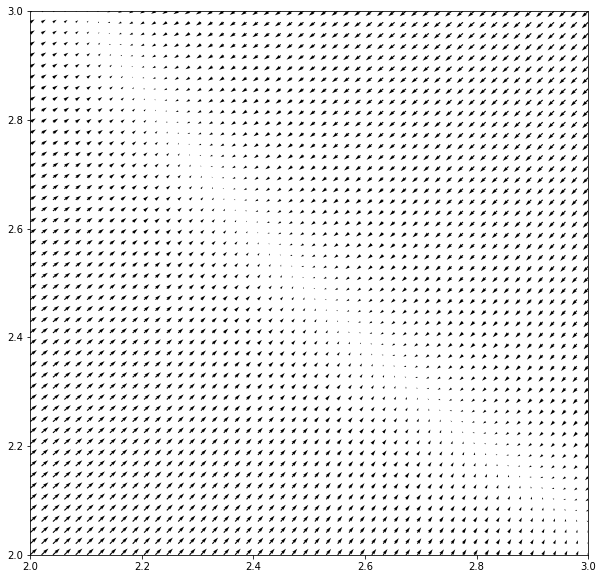

In [160]:
xrange = (2, 3)
yrange = (2, 3)
n = 50

x = np.linspace(*xrange, n)
y = np.linspace(*yrange, n)
x, y = np.meshgrid(x, y)
z = np.stack([x, y], axis=-1)
z = torch.tensor(z, dtype=torch.float32).view(-1, 2).to(device)

z_cond = torch.tensor(np.repeat(test_obs,z.shape[0],axis=0),dtype=torch.float32).to(device)

scores = model( z,z_cond ).detach().cpu().numpy()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)

plt.figure(figsize=(10,10))
plt.quiver(*z.cpu().T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(*xrange)
plt.ylim(*yrange)
plt.show()

Text(0.5, 1.0, 'True Fisher Score')

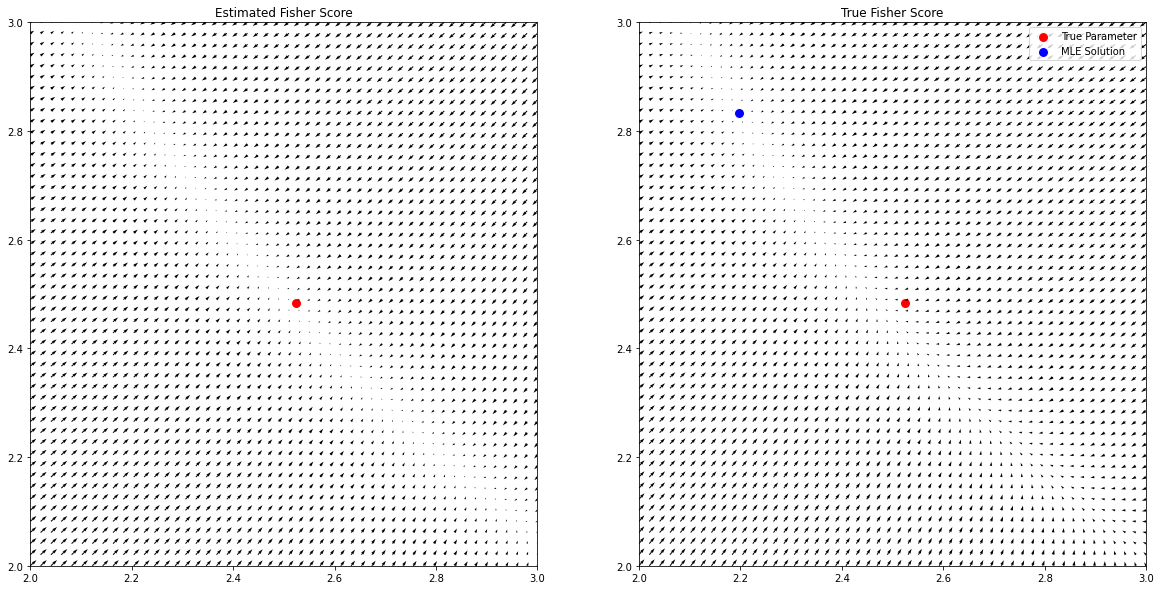

In [161]:
plot_range = [2,3]

xx = np.stack(np.meshgrid(np.linspace(*plot_range, 50), np.linspace(*plot_range, 50)), axis=-1).reshape(-1, 2)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(*test_theta[0], color='red', edgecolor='white', s=100)
plt.quiver(*z.cpu().T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(*plot_range)
plt.ylim(*plot_range)
plt.title('Estimated Fisher Score')

plt.subplot(1,2,2)
plt.scatter(*test_theta[0], color='red', edgecolor='white', s=100, label='True Parameter')
plt.scatter([mle_alpha], [mle_beta], color='blue', edgecolor='white', s=100, label='MLE Solution')
plt.quiver(*xx.T,*true_fs_log1p.T, width=0.002, color='black')
plt.xlim(*plot_range)
plt.ylim(*plot_range)
plt.legend(loc='upper right')
plt.title('True Fisher Score')



Text(0.5, 1.0, 'Relative error in y')

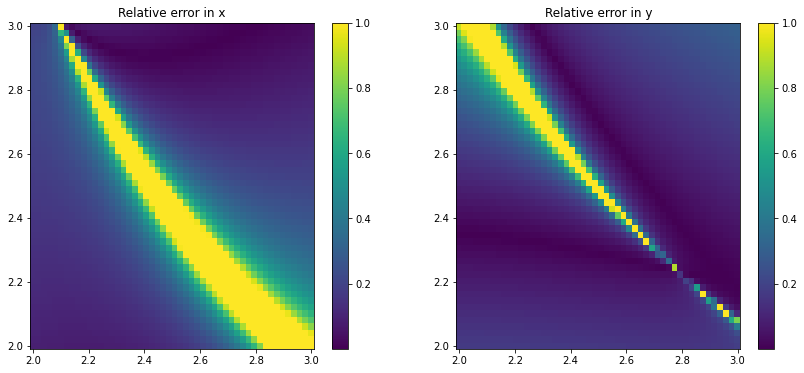

In [162]:
relative_error = np.abs((scores-true_fs)/(true_fs+1e-1))
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.pcolor(x, y,relative_error[:,0].reshape(50,50),vmax=1)
plt.colorbar()
plt.title('Relative error in x')
plt.subplot(122)
plt.pcolor(x, y,relative_error[:,1].reshape(50,50),vmax=1)
plt.colorbar()
plt.title('Relative error in y')


Text(0.5, 1.0, 'Relative error')

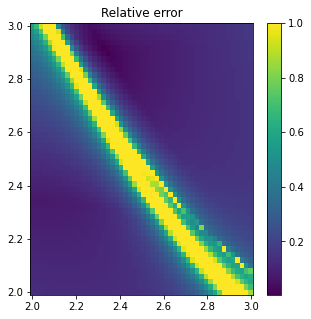

In [163]:
relative_error_all = (relative_error[:,0].reshape(50,50) + relative_error[:,1].reshape(50,50))/2

plt.figure(figsize=(5,5))

plt.pcolor(x, y, relative_error_all,vmax=1)

plt.colorbar()
plt.title('Relative error')



Text(0.5, 1.0, 'mse error')

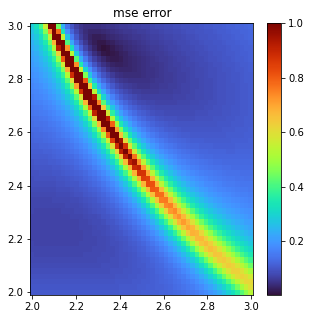

In [164]:
mse =( np.sqrt(((scores - true_fs)**2).mean(1))/(np.linalg.norm(true_fs, axis=-1, ord=2))).reshape(50,50)

plt.figure(figsize=(5,5))


plt.pcolor(x, y, mse,vmax=1,cmap='turbo')

plt.colorbar()
plt.title('mse error')


In [165]:
mle_alpha,mle_beta

(2.1977394260644667, 2.832091182865782)

In [152]:
#graident desend using model

sol = prior_thetas(1)
sdg_lr = 1e-3
path=[]
for i in range(10000):
    scores = model( torch.tensor(sol).float().to(device),torch.tensor(np.repeat(test_obs,1,axis=0),dtype=torch.float32).to(device) ).detach().cpu().numpy()
    sol = sol + sdg_lr * scores
    path.append(sol[0])


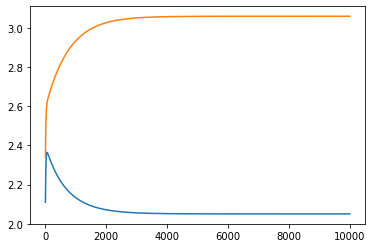

In [153]:
plt.plot(np.array(path))

In [155]:
test_theta,path[-1]

(array([[2.52393612, 2.48344085]]), array([2.05005873, 3.05935319]))

Text(0.5, 1.0, 'mse error')

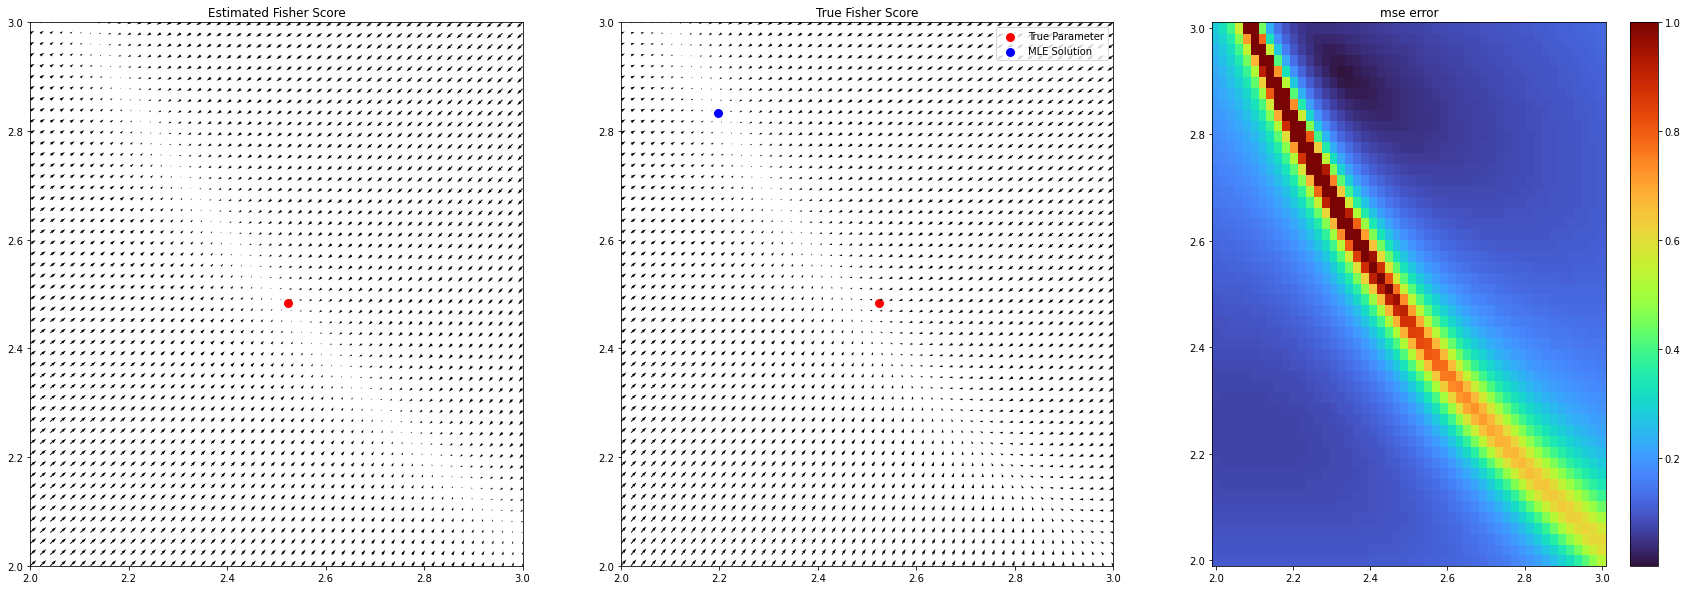

In [166]:
plot_range = [2,3]

xx = np.stack(np.meshgrid(np.linspace(*plot_range, 50), np.linspace(*plot_range, 50)), axis=-1).reshape(-1, 2)

plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.scatter(*test_theta[0], color='red', edgecolor='white', s=100)
plt.quiver(*z.cpu().T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(*plot_range)
plt.ylim(*plot_range)
plt.title('Estimated Fisher Score')

plt.subplot(1,3,2)
plt.scatter(*test_theta[0], color='red', edgecolor='white', s=100, label='True Parameter')
plt.scatter([mle_alpha], [mle_beta], color='blue', edgecolor='white', s=100, label='MLE Solution')
plt.quiver(*xx.T,*true_fs_log1p.T, width=0.002, color='black')
plt.xlim(*plot_range)
plt.ylim(*plot_range)
plt.legend(loc='upper right')
plt.title('True Fisher Score')

plt.subplot(1,3,3)
plt.pcolor(x, y, mse,vmax=1,cmap='turbo')
plt.colorbar()
plt.title('mse error')


In [167]:
def estimate_fisher_score(x,theta):

    with torch.no_grad():
        pos_score=model(theta,x)
        fs=pos_score#-prior_score

    return fs.cpu().numpy()#,pos_score.cpu().numpy(),prior_score.cpu().numpy()

def estimate_fisher_information(theta,N_trial=10000):

    true_thetas = torch.tensor(np.repeat(theta, N_trial, axis=0)).float()
    true_thetas_samples = gamma_simulator(true_thetas)

    #calcuate the fisher score at every sample in true_thetas_samples
    est_fs=estimate_fisher_score(torch.tensor(true_thetas_samples).float().to(device),torch.tensor(true_thetas).float().to(device))
    true_fs=gamma_fisher_score(theta,true_thetas_samples)

    # est_fs= est_fs-np.mean(est_fs,axis=0)
    #estimate fisher matrix through averaging
    estimated_fm=(est_fs[:,:,None]*est_fs[:,None,:]).mean(axis=0)
    true_fm=gamma_fisher_information(theta)

    return estimated_fm,est_fs,true_fm,true_fs
    

In [182]:
test_theta=prior_thetas(1)
efm,efs,tfm,tfs=estimate_fisher_information((test_theta))

/tmp/ipykernel_1497881/3076440463.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  est_fs=estimate_fisher_score(torch.tensor(true_thetas_samples).float().to(device),torch.tensor(true_thetas).float().to(device))


In [183]:
efm,tfm

(array([[45.790024, 37.23783 ],
        [37.23783 , 31.52404 ]], dtype=float32),
 array([[[47.25445768, 35.37787137],
         [35.37787137, 32.26873368]]]))

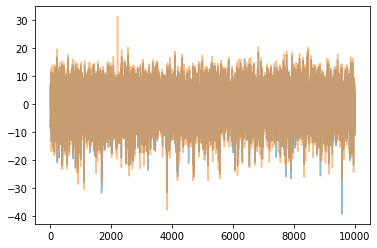

In [169]:
plt.plot(efs,alpha=0.5)

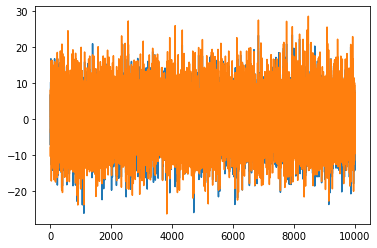

In [170]:
plt.plot(tfs)

(array([[36.534554, 39.3216  ],
        [39.3216  , 43.64348 ]], dtype=float32),
 array([[[42.77101196, 41.960147  ],
         [41.960147  , 49.35892885]]]))

In [172]:
xx = np.stack(np.meshgrid(np.linspace(2, 3, 50), np.linspace(2, 3, 50)), axis=-1).reshape(-1, 2)
true_fm=gamma_fisher_information(xx)
estimated_fm=np.zeros_like(true_fm)
for idx,one_x in enumerate(xx):
    estimated_fm[idx]=estimate_fisher_information(one_x[np.newaxis,:])[0]

# Perform the plots
# plt.figure(figsize=(16,12))
# plt.scatter(*thetas.detach().cpu().T, alpha=0.3, color='red', edgecolor='white', s=40)
# plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

/tmp/ipykernel_1497881/3076440463.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  est_fs=estimate_fisher_score(torch.tensor(true_thetas_samples).float().to(device),torch.tensor(true_thetas).float().to(device))


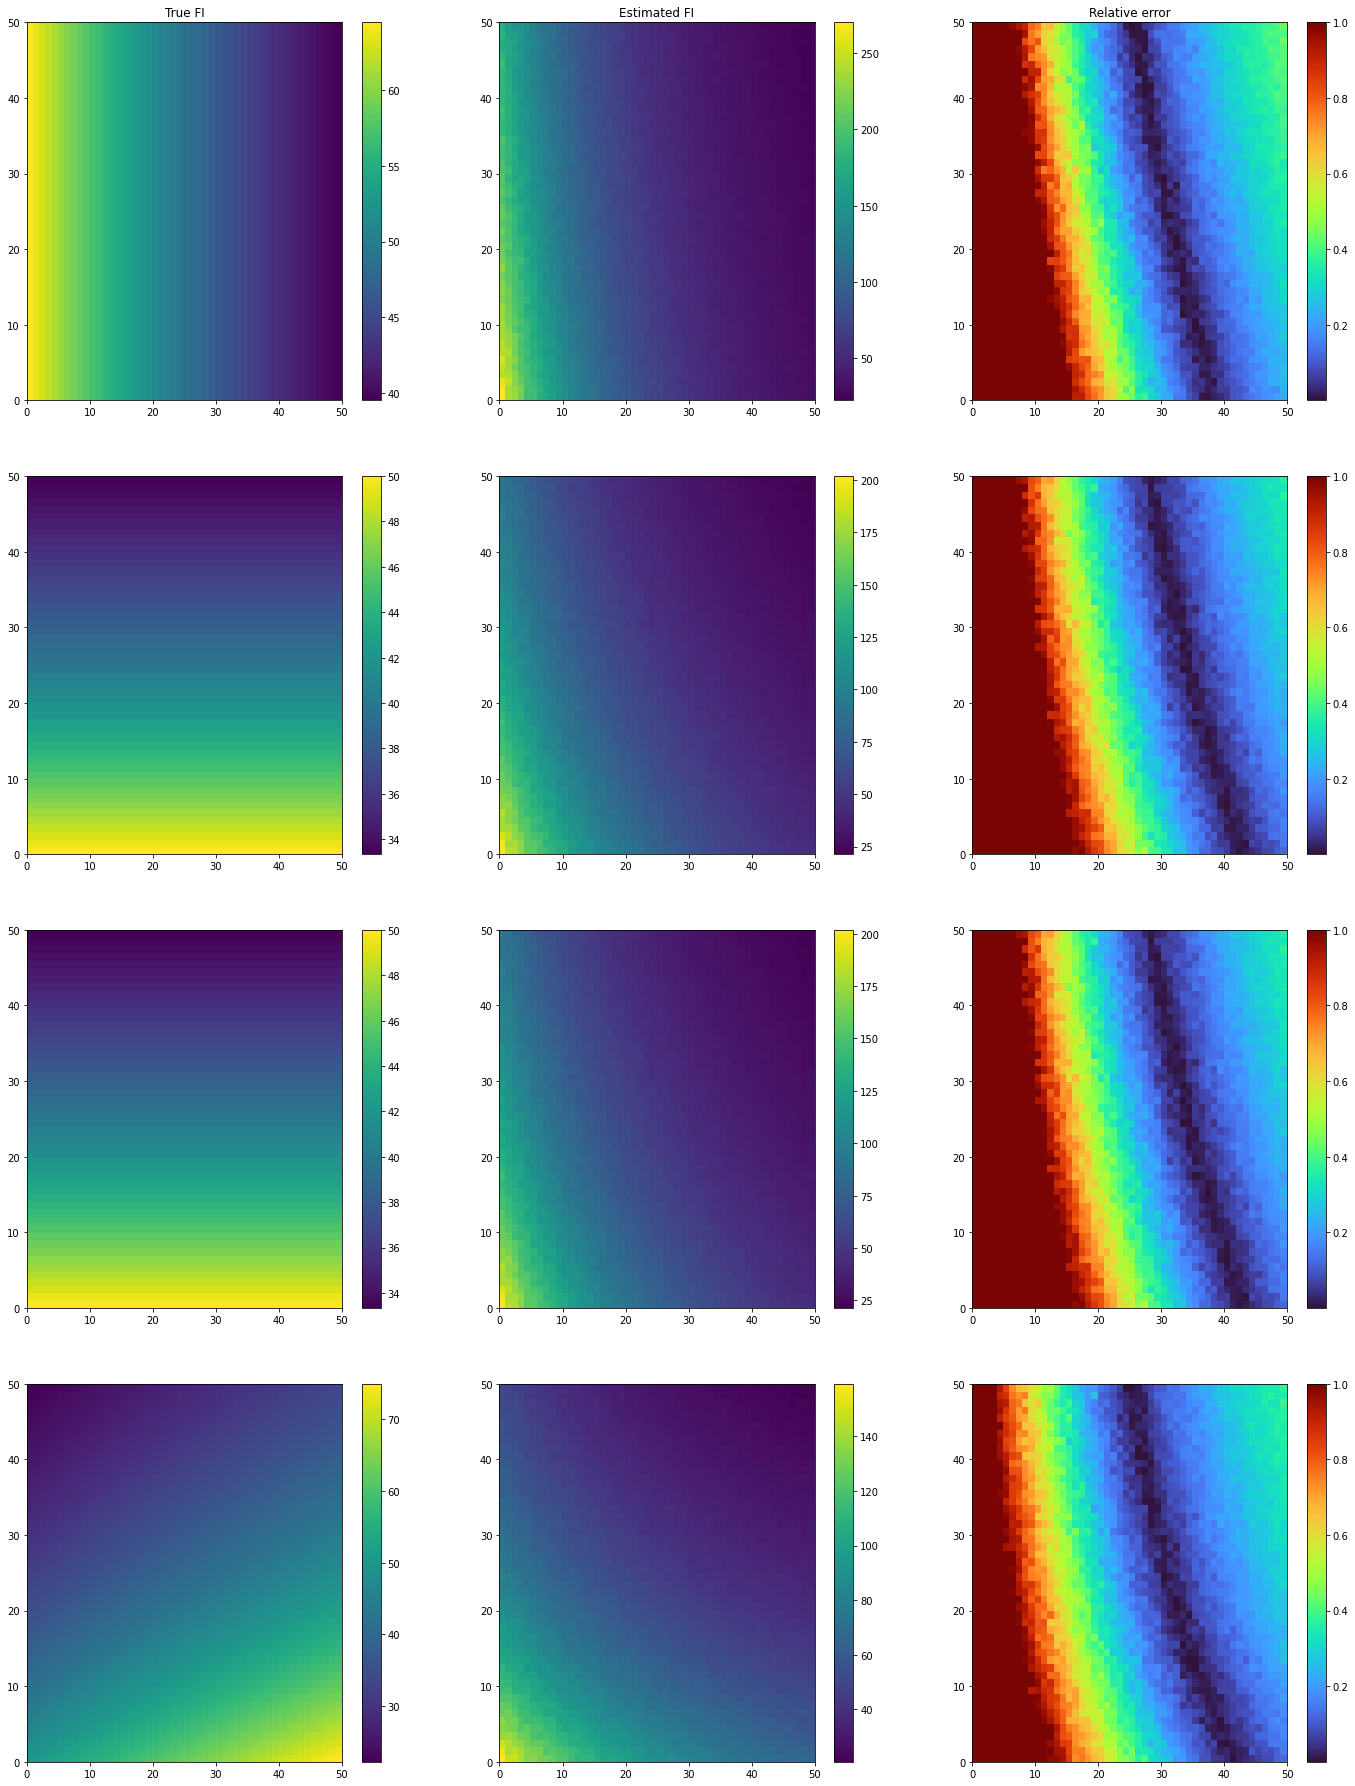

In [173]:


plt.figure(figsize=(24,32))
plt.subplot(4,3,1)
plt.pcolor(true_fm[:,0,0].reshape(50,50))
plt.colorbar()
plt.title('True FI')

plt.subplot(4,3,2)
plt.pcolor(estimated_fm[:,0,0].reshape(50,50))
plt.colorbar()
plt.title('Estimated FI')

plt.subplot(4,3,3)
plt.pcolor(np.abs((estimated_fm[:,0,0]-true_fm[:,0,0])/true_fm[:,0,0]).reshape(50,50),cmap='turbo',vmax=1)
plt.colorbar()
plt.title('Relative error')

plt.subplot(4,3,4)
plt.pcolor(true_fm[:,0,1].reshape(50,50))
plt.colorbar()
# plt.title('Relative error')

plt.subplot(4,3,5)
plt.pcolor(estimated_fm[:,0,1].reshape(50,50))
plt.colorbar()
# plt.title('Fisher matrix 1,2')

plt.subplot(4,3,6)
plt.pcolor(np.abs((estimated_fm[:,0,1]-true_fm[:,0,1])/true_fm[:,0,1]).reshape(50,50),cmap='turbo',vmax=1)
plt.colorbar()
# plt.title('Fisher matrix 1,1')

plt.subplot(4,3,7)
plt.pcolor(true_fm[:,1,0].reshape(50,50))
plt.colorbar()
# plt.title('Fisher matrix 2,1')

plt.subplot(4,3,8)
plt.pcolor(estimated_fm[:,1,0].reshape(50,50))
plt.colorbar()
# plt.title('Fisher matrix 2,1')

plt.subplot(4,3,9)
plt.pcolor(np.abs((estimated_fm[:,1,0]-true_fm[:,1,0])/true_fm[:,1,0]).reshape(50,50),cmap='turbo',vmax=1)
plt.colorbar()
# plt.title('Fisher matrix 1,1')

plt.subplot(4,3,10)
plt.pcolor(true_fm[:,1,1].reshape(50,50))
plt.colorbar()
# plt.title('Fisher matrix 2,2')

plt.subplot(4,3,11)
plt.pcolor(estimated_fm[:,1,1].reshape(50,50))
plt.colorbar()
# plt.title('Fisher matrix 2,2')

plt.subplot(4,3,12)
plt.pcolor(np.abs((estimated_fm[:,1,1]-true_fm[:,1,1])/true_fm[:,1,1]).reshape(50,50),cmap='turbo',vmax=1)
plt.colorbar()
# plt.title('Fisher matrix 1,1')

